# Online Training Face Recognition MTCNN, FaceNet, dan ...

## Import Library & Load saved faces embeddings

In [1]:
# Import Library
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Load faces_embedding (feature vector)
try:
    data = np.load('faces_embeddings_done.npz')
    EMBEDDED_X = list(data['arr_0'])
    Y = list(data['arr_1'])
except FileNotFoundError:
    EMBEDDED_X = []
    Y = []

# Check the contents of EMBEDDED_X and Y
print("Contents of EMBEDDED_X:")
print(EMBEDDED_X)
print("\nContents of Y:")
print(Y)

Contents of EMBEDDED_X:
[array([ 1.80720128e-02,  2.05520988e-02, -1.60805397e-02,  1.57870296e-02,
       -3.78457420e-02,  5.32976678e-03,  4.07598913e-03,  5.15183397e-02,
        8.93559456e-02,  1.55622810e-02,  4.00752798e-02,  4.77995723e-02,
        2.42026639e-03,  3.86101678e-02, -2.23360714e-02,  1.23765636e-02,
        8.69789496e-02,  5.75899407e-02, -5.16845100e-02,  2.19131634e-02,
        1.39965862e-03, -1.23095503e-02,  7.86172971e-02, -7.31251761e-02,
       -5.18348627e-02, -2.64876503e-02, -5.39418962e-03,  2.12285258e-02,
        4.25835587e-02, -4.32841294e-02,  7.10043833e-02,  3.81093360e-02,
       -2.55566160e-03,  4.55939658e-02,  1.25547452e-02,  8.33810959e-03,
       -3.48237418e-02, -4.82315831e-02, -8.80855415e-03,  6.69934005e-02,
        7.76411965e-02, -8.82871449e-02,  2.08891649e-03,  4.01512198e-02,
       -3.60969491e-02, -2.74323579e-02, -5.72836166e-03,  4.75257151e-02,
       -6.95097744e-02, -3.23311836e-02, -2.29364894e-02, -8.67849123e-03,


In [3]:
# Import MTCNN for image detection
from mtcnn.mtcnn import MTCNN

# Initiate MTCNN Model
img_detector = MTCNN()

## Automate the preprocessing 

In [4]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    
    def preprocess_image(self, filename, new_size=(480, 480)):
        # Load the image
        t_img = cv.imread(filename)

        # Convert the image to RGB
        t_img = cv.cvtColor(t_img, cv.COLOR_BGR2RGB)

        # Resize the image to the new size while maintaining aspect ratio
        height, width, _ = t_img.shape
        scale = min(new_size[0] / width, new_size[1] / height)
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized_img = cv.resize(t_img, (new_width, new_height))

        # Detect faces in the resized image
        detections = self.detector.detect_faces(resized_img)
        if not detections:
            raise Exception("No faces detected in the image.")

        # Extract the coordinates and size of the bounding box from the first detection result
        x, y, w, h = detections[0]['box']

        # Scale the coordinates back to the original image size
        x = int(x / scale)
        y = int(y / scale)
        w = int(w / scale)
        h = int(h / scale)

        # Crop the detected face region from the original image using the bounding box coordinates
        face_img = t_img[y:y+h, x:x+w]

        # Resize the cropped face image to 160x160
        face_img = cv.resize(face_img, self.target_size)

        return face_img
    
    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.preprocess_image(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)

    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')

In [5]:
# Initiate the FACELOADING class with the dataset directory path
faceloading = FACELOADING("data_online_training")

# Load the face images (X) and their corresponding labels (Y) from the dataset
X, new_Y = faceloading.load_classes()

1/1 [==============================] - 0s 16ms/step
Loaded successfully: 5


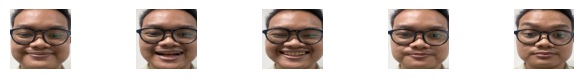

In [6]:
# Display the loaded face images.
plt.figure(figsize=(16, 12))
for num, image in enumerate(X):
    ncols = 10
    nrows = len(Y) // ncols + 1
    plt.subplot(nrows, ncols, num + 1)
    plt.imshow(image)
    plt.axis('off')

## FaceNet

In [7]:
# import library Facenet
from keras_facenet import FaceNet

# Instantiate the FaceNet model
embedder = FaceNet()

# Define a function to get the embedding of a face image
def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [8]:
# Loop through each image in the dataset X to get the embedding for the current image and append it to the list
for img in X:
    EMBEDDED_X.append(get_embedding(img))

# Append new labels to existing labels
Y.extend(new_Y)

1/1 [==============================] - 0s 67ms/step


In [9]:
# Display updated data

print("Embeddings:")
print(EMBEDDED_X)

print("\nLabels:")
print(Y)

Embeddings:
[array([ 1.80720128e-02,  2.05520988e-02, -1.60805397e-02,  1.57870296e-02,
       -3.78457420e-02,  5.32976678e-03,  4.07598913e-03,  5.15183397e-02,
        8.93559456e-02,  1.55622810e-02,  4.00752798e-02,  4.77995723e-02,
        2.42026639e-03,  3.86101678e-02, -2.23360714e-02,  1.23765636e-02,
        8.69789496e-02,  5.75899407e-02, -5.16845100e-02,  2.19131634e-02,
        1.39965862e-03, -1.23095503e-02,  7.86172971e-02, -7.31251761e-02,
       -5.18348627e-02, -2.64876503e-02, -5.39418962e-03,  2.12285258e-02,
        4.25835587e-02, -4.32841294e-02,  7.10043833e-02,  3.81093360e-02,
       -2.55566160e-03,  4.55939658e-02,  1.25547452e-02,  8.33810959e-03,
       -3.48237418e-02, -4.82315831e-02, -8.80855415e-03,  6.69934005e-02,
        7.76411965e-02, -8.82871449e-02,  2.08891649e-03,  4.01512198e-02,
       -3.60969491e-02, -2.74323579e-02, -5.72836166e-03,  4.75257151e-02,
       -6.95097744e-02, -3.23311836e-02, -2.29364894e-02, -8.67849123e-03,
        5.98

In [10]:
# Initialize an empty list to store unique labels in order
unique_labels = []

# Set to track seen labels
seen_labels = set()

# Iterate through each label in Y
for label in Y:
    # Check if the label has not been seen before
    if label not in seen_labels:
        # Add the label to the list of unique labels
        unique_labels.append(label)
        # Add the label to the set of seen labels
        seen_labels.add(label)

# Print unique labels in order
print("Labels:")
print(unique_labels)

Labels:
['abed', 'budi_adrianto', 'gibran', 'iyal', 'vicky', 'josua']


In [11]:
# Save the updated embeddings and labels into a compressed NumPy archive file (.npz)
np.savez_compressed('updated_faces_embeddings_done.npz', EMBEDDED_X, Y)